# Song lyrics exploration - Part 3: Word clouds

Word clouds are a fun and oftentimes helpful technique for visualizing natural language data. They can show words scaled by any metric, although term frequency and term-frequency-inverse-document-frequency (TF-IDF) are the most common metrics. For a multi-class or multi-label classification problem, word clouds can highlight the similarities and differences between separate classes by treating each class as its own document to compare with all others. The word clouds seen here were made with the `WordCloud` generator by [amueller](https://github.com/amueller/word_cloud), with pre-processing done via `gensim` and `nltk`.

In the case of heavy metal genre classification, term frequency alone would not be very illuminating: the genres visualized here share a lot of common themes. TF-IDF does much better at picking out the words that are unique to a genre: black metal lyrics deal with topics like the occult, religion, and nature; death metal focuses on the obscene and horrifying; heavy metal revolves around themes more familiar to rock and pop; power metal adopts the vocabulary of fantasies and histories; and thrash metal sings of violence, war, and... beer? The full corpus word cloud shows themes common to all heavy metal genres.

### Imports

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from wordcloud import WordCloud
from nltk.corpus import words as nltk_words
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer


ENGLISH_WORDS = set(nltk_words.words())


def tokenize(s, english_only=True, stopwords=None, min_len=3):
    tokenizer = RegexpTokenizer(r'[\w+\-\']+')
    words = [w.lower()
             .replace("'s", '')
             .replace("in'", 'ing')
             for w in tokenizer.tokenize(s.strip())]
    if english_only:
        new_words = []
        for w in words:
            lemma = wordnet.morphy(w)
            if lemma is not None:
                if lemma in ENGLISH_WORDS:
                    new_words.append(w)
            elif w in ENGLISH_WORDS:
                new_words.append(w)
        words = new_words
    if stopwords is not None:
        words = [w for w in words if w not in stopwords]
    if min_len > 0:
        words = [w for w in words if len(w) >= min_len]
    return words

### Data

In [26]:
# df = pd.read_csv('../songs-ml-1pct.csv')
# genres = df.columns[1:]
df = pd.read_csv('../bands-1pct.csv')
genre_cols = [c for c in df.columns if 'genre_' in c]
genres = [c.replace('genre_', '') for c in genre_cols]

In [145]:
def tokenizer(s):
    return [word for word in s.split() if len(word) >= 4]

In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), tokenizer=tokenizer, min_df=0.5, max_df=0.9)#, tokenizer=tokenize, min_df=0.9, max_df=0.95)
# vectorizer = CountVectorizer(stop_words=stopwords.words('english'), tokenizer=tokenizer, min_df=0.1, max_df=0.9)
corpus = []
for genre, col in zip(genres, genre_cols):
    other_cols = [c for c in genre_cols if c != col]
    words = df[(df[col] == 1) & (df[other_cols] == 0).all(axis=1)].words
    corpus.append(' '.join(words))
X = vectorizer.fit_transform(corpus)

black


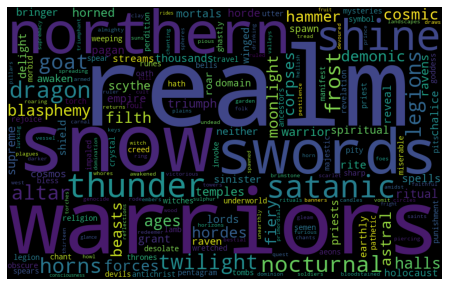

death


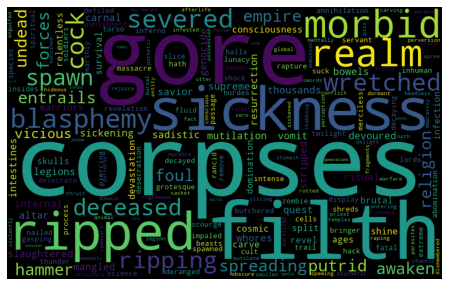

deathcore


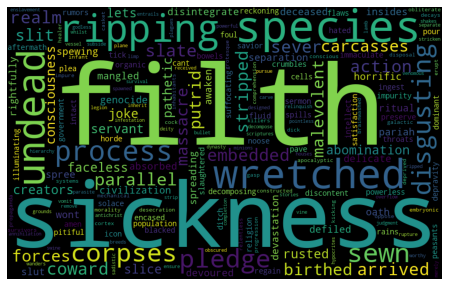

doom


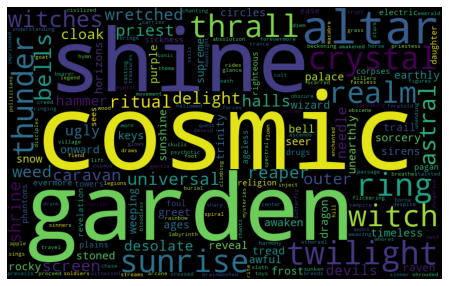

folk


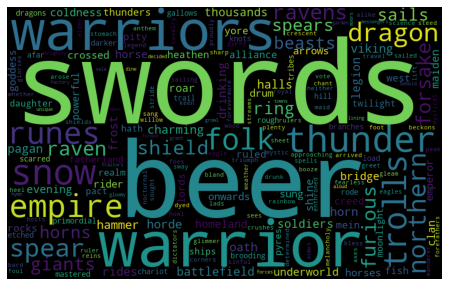

gothic


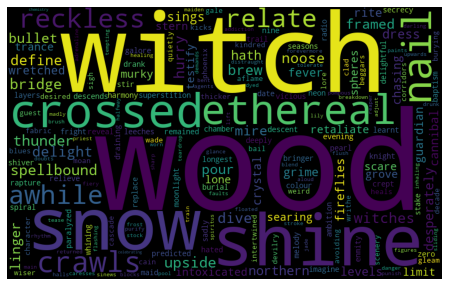

grindcore


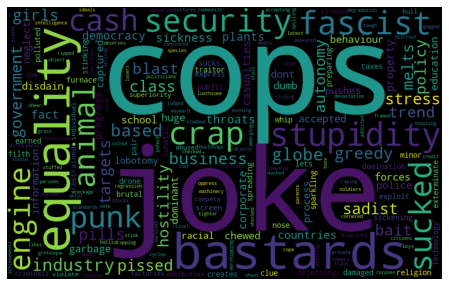

heavy


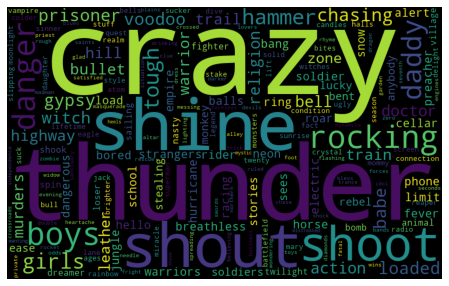

metalcore


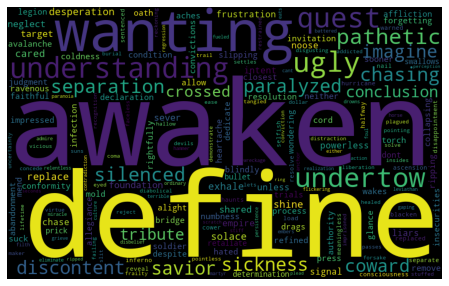

power


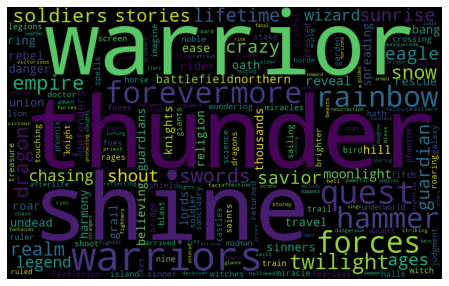

progressive


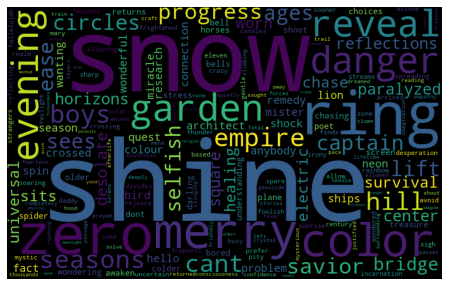

symphonic


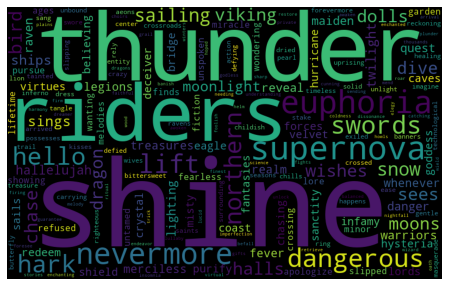

thrash


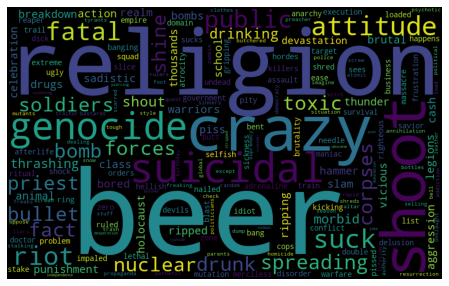

In [161]:
vocabulary = vectorizer.get_feature_names()
for i, genre in enumerate(genres):
    print(genre)
    freqs = X.toarray()[i,:]
    word_freqs = dict(zip(vocabulary, freqs))
    word_cloud = WordCloud(width=800, height=500).fit_words(word_freqs)
    plt.figure(figsize=(8, 5))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

In [213]:
tfidf_bands = pd.DataFrame(X_bands.toarray(), index=df.name, columns=vocabulary)

In [217]:
tfidf_bands.to_csv('test.csv', index_label='')

Blind Guardian


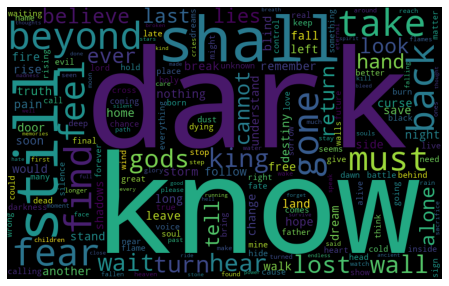

Opeth


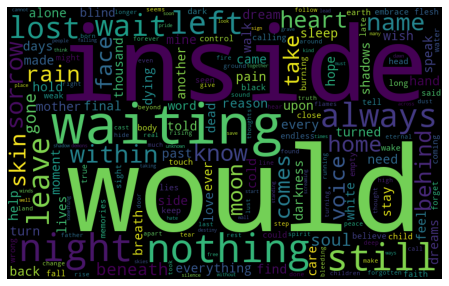

Slayer


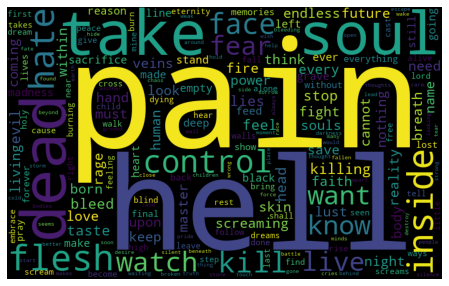

Burzum


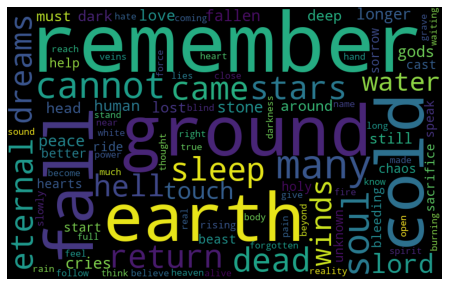

Black Sabbath


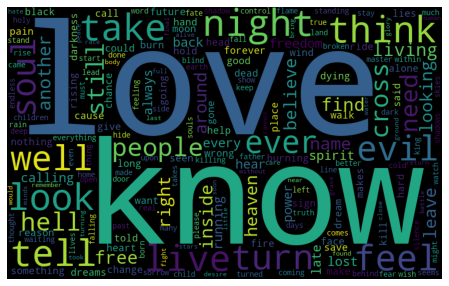

Megadeth


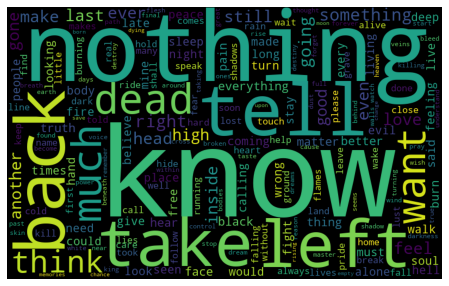

Amon Amarth


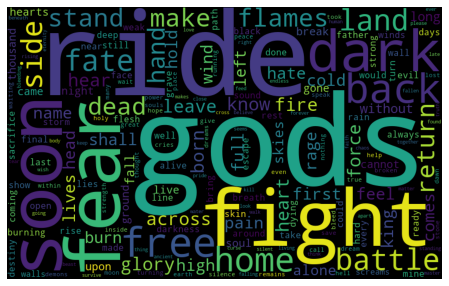

Deathspell Omega


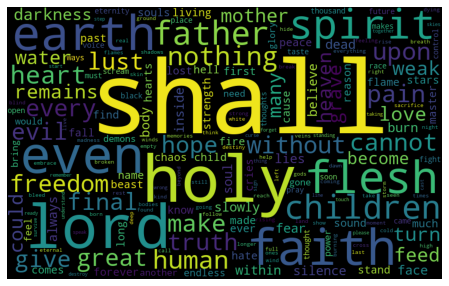

Ahab


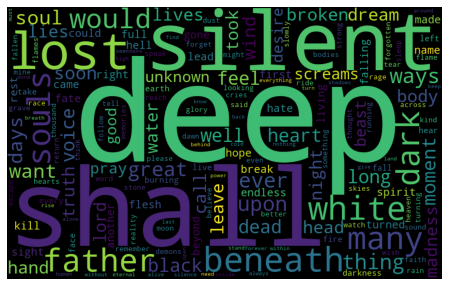

Archspire


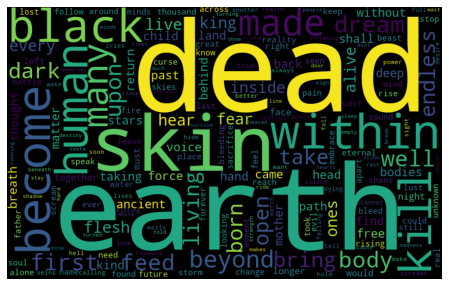

In [193]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), tokenizer=tokenizer, min_df=0.5, max_df=0.9, sublinear_tf=False, max_features=300)
X_bands = vectorizer.fit_transform(list(df.words))

tfidf_bands = pd.DataFrame(X_bands.toarray(), index=df.name, columns=vocabulary)

vocabulary = vectorizer.get_feature_names()
for i, name in df.name.items():
    if name.lower() in ['opeth', 'archspire', 'deathspell omega', 'blind guardian', 'amon amarth', 'burzum', 'megadeth', 'slayer', 'black sabbath', 'ahab']:
        print(name)
        freqs = X_bands.toarray()[i,:]
        word_freqs = dict(zip(vocabulary, freqs))
        word_cloud = WordCloud(width=800, height=500).fit_words(word_freqs)
        plt.figure(figsize=(8, 5))
        plt.imshow(word_cloud)
        plt.axis('off')
        plt.show()

### Combine songs from same genre into documents

Before combining all the songs into a corpus, [stop words](https://en.wikipedia.org/wiki/Stop_word) (common words that aren't critical to the meaning of a text, e.g. "the" and "of") are removed using a directory of stop words in various languages. I don't recall where I got my stop words but it's easy to find repositories of stop words like [Alir3z4/stop-words](https://github.com/Alir3z4/stop-words) and [6/stopwords-json](https://github.com/6/stopwords-json).

In [12]:
tokenize_kwargs = dict(english_only=True, stopwords=stopwords.words('english'))
texts = []
for genre in genres:
    song_tokens = df[df[genre] == 1].lyrics.apply(lambda x: ' '.join(tokenize(x, **tokenize_kwargs)))
    genre_tokens = ' '.join(song_tokens).split()
    texts.append(genre_tokens)

In [4]:
print("genre word counts:")
for i, genre in enumerate(genres):
    print(f"{genre:<15}{len(texts[i])}")

genre word counts:
black          594254
death          1212615
deathcore      61537
doom           241094
folk           127748
gothic         154844
grindcore      111903
heavy          549375
metalcore      103146
power          735640
progressive    368762
symphonic      213482
thrash         631127


In [5]:
print("genre vocabulary sizes:")
for i, genre in enumerate(genres):
    print(f"{genre:<15}{len(set(texts[i]))}")

genre vocabulary sizes:
black          26042
death          34248
deathcore      10069
doom           17191
folk           13812
gothic         13786
grindcore      16513
heavy          19455
metalcore      10634
power          20461
progressive    20778
symphonic      16251
thrash         24215


# Word cloud

In [13]:
def get_wordcloud_frequencies(texts, tfidf=False, min_tf=0, min_tf_pct=0, min_df=1):
    print("creating dictionary")
    id2word = Dictionary(texts)
    print("generating bag-of-words representation")
    corpus = [id2word.doc2bow(text) for text in texts]
    if min_tf > 0:
        print("filtering out words that occur less than 'min_tf' times in a document")
        corpus = [
            [(token, count) for (token, count) in doc if count > min_tf]
            for doc in corpus
        ]
    if min_tf_pct > 0:
        print("filtering out words that comprises less than 'min_tf_pct' of a document")
        assert min_tf_pct <= 100, "min_tf_pct must be in the interval [0, 100]"
        text_sizes = [len(text) for text in texts]
        corpus = [
            [(token, count) for (token, count) in doc if count > 0.01 * min_tf_pct * text_size]
            for (doc, text_size) in zip(corpus, text_sizes)
        ]
    if min_df > 1:
        print("filtering out words that occur in fewer than 'min_df' documents")
        ids = [[token for (token, count) in doc] for doc in corpus]
        ids_unique = set(sum(ids, []))
        ids_unique_filtered = []
        for id_ in ids_unique:
            if sum(id_ in text_ids for text_ids in ids) > min_df:
                ids_unique_filtered.append(id_)
        corpus = [
            [(token, count) for (token, count) in doc if token in ids_unique_filtered]
            for doc in corpus
        ]
    if tfidf:
        print("generating TF-IDF model")
        tfidf = TfidfModel(corpus)
        corpus = [tfidf[doc] for doc in corpus]
    print("generating frequency dictionaries for WordCloud")
    out = []
    for doc in corpus:
        out.append({id2word[token]: count for token, count in doc})
    return out

### Full corpus

creating dictionary
generating bag-of-words representation
generating frequency dictionaries for WordCloud


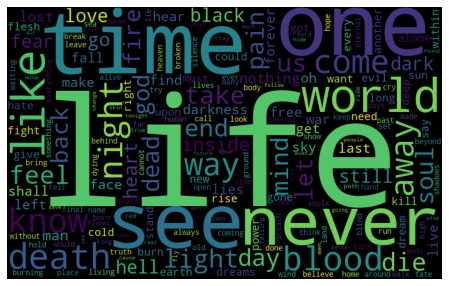

In [14]:
full_text = sum(texts, [])
word_freqs = get_wordcloud_frequencies([full_text])
word_cloud = WordCloud(width=800, height=500).fit_words(word_freqs[0])
plt.figure(figsize=(8, 5))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### By genre

creating dictionary
generating bag-of-words representation
filtering out words that comprises less than 'min_tf_pct' of a document
generating TF-IDF model
generating frequency dictionaries for WordCloud


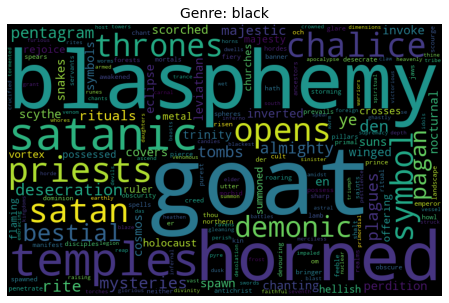

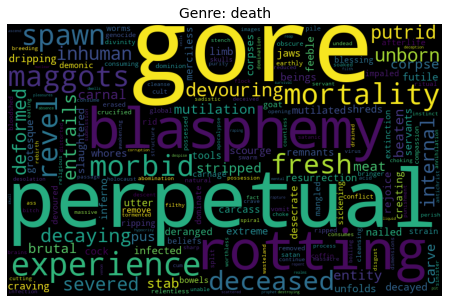

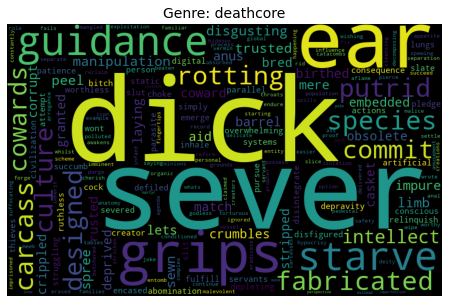

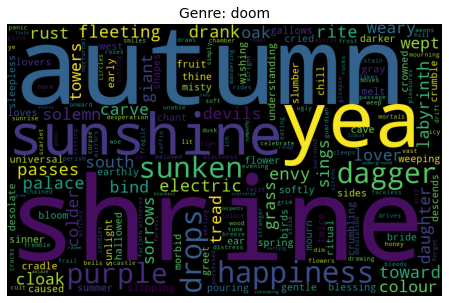

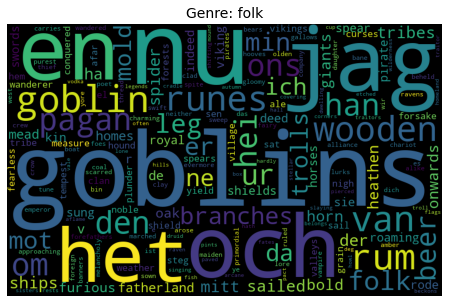

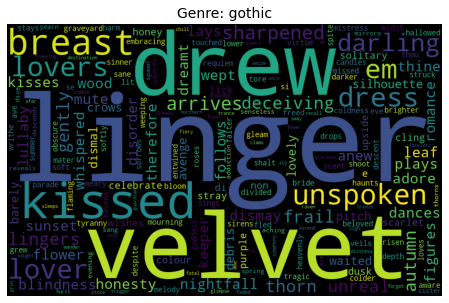

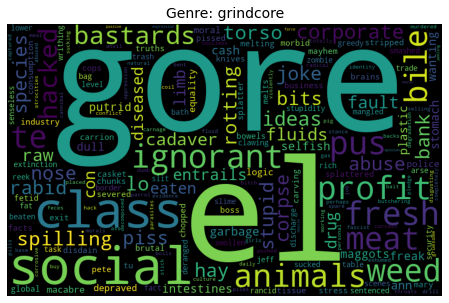

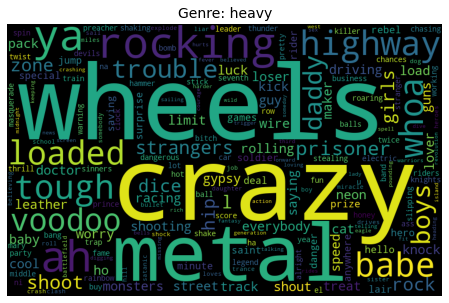

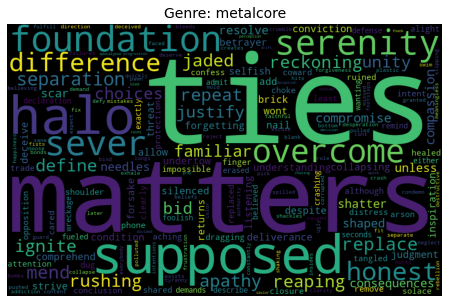

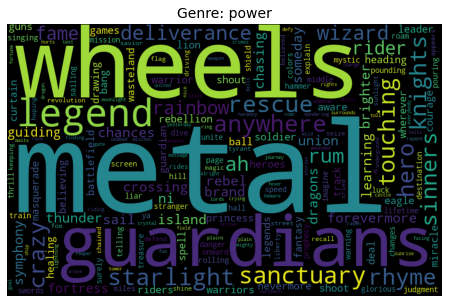

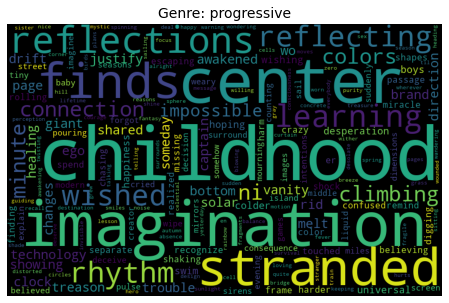

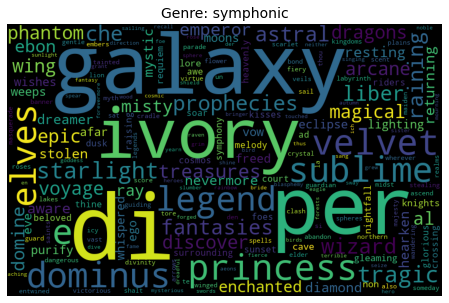

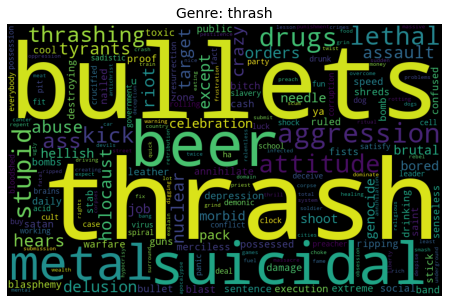

In [16]:
word_freqs = get_wordcloud_frequencies(texts, tfidf=True, min_tf_pct=0.01)

for i, genre in enumerate(genres):
    word_cloud = WordCloud(width=800, height=500).fit_words(word_freqs[i])
    plt.figure(figsize=(8, 5))
    plt.imshow(word_cloud)
    plt.title(f'Genre: {genre}', fontsize=14)
    plt.axis('off')
    plt.show()